# Clustering Recency, Frequency, and Monetary (RFM) individually

We're going to explore clustering recency, frequency, and monetary value indivudually.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import subprocess
import datetime
import re

from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import boxcox
from scipy.stats import mannwhitneyu

from statsmodels.stats.weightstats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

### RECENCY, FREQUENCY, MONETARY ANALYSIS 
Objective is to find the RFM for each customer to determing Low, Medium and High Value Customers

In [6]:
home_dir = '/home/jupyter/data_science_challenges/business_data_science'

data_dir = os.path.join(home_dir, 'data/external/OnlineRetail.csv')



In [8]:
df = pd.read_csv(data_dir, encoding="unicode_escape").drop_duplicates().dropna().reset_index(drop=True)

# Changing data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# time series variables
df['date'] = pd.to_datetime(df.InvoiceDate).dt.date
df['year'] = pd.to_datetime(df.InvoiceDate).dt.year
df['month'] = pd.to_datetime(df.InvoiceDate).dt.month
df['day'] = pd.to_datetime(df.InvoiceDate).dt.day
df['yearmo'] = pd.to_datetime(df.InvoiceDate).dt.strftime('%Y%m')
# new variable

df['Revenue'] = df['Quantity'] * df['UnitPrice']

df = df.loc[df.Country == 'United Kingdom']

#### Recency

In [11]:
# We drop returns.
new_df = df.loc[~df.InvoiceNo.str.contains('C')].copy()
new_df['Recency'] =  (pd.to_datetime(new_df.InvoiceDate).max() - new_df.InvoiceDate).dt.days 
r_df = new_df.groupby(['CustomerID']).agg({'InvoiceDate': 'min'}).reset_index()\
.merge(new_df[['CustomerID', 'InvoiceDate','Recency']], on=['CustomerID','InvoiceDate'], how='inner')\
.drop_duplicates().reset_index(drop=True).drop(['InvoiceDate'], axis=1)


#### Frequency
We are going to use the formula:
Frequency = 1 / Median( Time between Purchases)

In [12]:
new_df = df.loc[~df.InvoiceNo.str.contains('C')].copy()
f_df = new_df[['InvoiceDate','CustomerID']].drop_duplicates().sort_values(by=['CustomerID','InvoiceDate'], ascending=True).reset_index(drop=True)

#Creating difference between invoice dates per person
f_df['Offset'] = f_df.groupby(['CustomerID'])['InvoiceDate'].diff().dt.seconds

# Creating Count per user
f_df = f_df.merge(\
    f_df.groupby(['CustomerID']).agg(Count = ('InvoiceDate', 'count')).reset_index()\
           ,on=['CustomerID'], how='inner')

# Finding folks who only had one interaction and giving them an Offset that is differenced from the latest day in the dataset
f_df.loc[f_df.Count == 1, 'Offset'] = (f_df.InvoiceDate.max() - f_df.InvoiceDate).dt.seconds

# Dropping the first occurance of a invoicedate.  Not needed to make agg.
f_df = f_df.loc[~(f_df.Offset.isna())]

f_df = f_df.groupby(['CustomerID']).agg(Frequency = ('Offset','median')).reset_index()

#f_df['FrequencyHertz'] = 1/f_df.Frequency

#### Monetary

In [13]:
# We use DF instead of new_df here because we want to penalize users for their returns.
m_df = df[['CustomerID','Revenue']].groupby('CustomerID').agg(Revenue = ('Revenue', 'sum')).reset_index()

In [14]:
final_df = r_df.merge(f_df, on='CustomerID', how='inner').merge(m_df, on='CustomerID', how='inner')

In [44]:
df_clusters = final_df.copy()
cols = ['Recency', 'Frequency', 'Revenue']
models = [AgglomerativeClustering(n_clusters=3), KMeans(n_clusters=3)]
#models = [KMeans(n_clusters=3)]
for c in cols:
    data = np.array(final_df[c]).reshape(-1, 1)
    for model in models:
        df_clusters[c + '_' + model.__class__.__name__] = model.fit_predict(data)

### CLUSTER ANALYSIS

#### Checking Recency

In [39]:
df_clusters.groupby('Recency_KMeans').Recency.describe()

,count,mean,std,min,25%,50%,75%,max
Recency_KMeans,,,,,,,,
0,1238.0,225.455574,38.843269,146.0,194.25,233.0,260.0,282.0
1,1159.0,64.869715,37.587128,0.0,35.00,62.0,88.0,145.0
2,1524.0,339.977034,29.592662,283.0,314.00,357.0,366.0,373.0


In [46]:
df_clusters.groupby('Recency_AgglomerativeClustering').Recency.describe()

,count,mean,std,min,25%,50%,75%,max
Recency_AgglomerativeClustering,,,,,,,,
0,2209.0,313.928022,46.844899,224.0,273.0,316.0,364.0,373.0
1,1120.0,62.198214,35.350233,0.0,33.0,60.0,85.0,137.0
2,592.0,184.618243,23.942250,138.0,165.0,185.0,206.0,222.0


#### Checking Frequency

In [40]:
df_clusters.groupby('Frequency_KMeans').Frequency.describe()

,count,mean,std,min,25%,50%,75%,max
Frequency_KMeans,,,,,,,,
0,1747.0,8323.943904,5977.455695,0.0,3360.0,7620.0,12240.0,25440.0
1,1600.0,77634.843750,5825.446560,60360.0,73845.0,78540.0,82320.0,86340.0
2,574.0,42630.731707,5601.766596,25800.0,40237.5,42735.0,45322.5,60120.0


In [47]:
df_clusters.groupby('Frequency_AgglomerativeClustering').Frequency.describe()

,count,mean,std,min,25%,50%,75%,max
Frequency_AgglomerativeClustering,,,,,,,,
0,1777.0,8661.322454,6466.039270,0.0,3420.0,7740.0,12480.0,31740.0
1,1616.0,77438.836634,6121.857840,55110.0,73620.0,78480.0,82275.0,86340.0
2,528.0,42983.693182,3875.639654,32700.0,40582.5,42855.0,45300.0,53940.0


#### Checking Revenue

In [41]:
df_clusters.groupby('Revenue_KMeans').Revenue.describe()

,count,mean,std,min,25%,50%,75%,max
Revenue_KMeans,,,,,,,,
0,3892.0,1322.883215,2051.979824,-1165.30,286.565,623.335,1492.0625,21535.90
1,2.0,221880.330000,48872.618563,187322.17,204601.250,221880.330,239159.4100,256438.49
2,27.0,43102.956296,16007.049228,25748.35,28532.220,36352.870,53698.7150,88125.38


In [48]:
df_clusters.groupby('Revenue_AgglomerativeClustering').Revenue.describe()

,count,mean,std,min,25%,50%,75%,max
Revenue_AgglomerativeClustering,,,,,,,,
0,3892.0,1322.883215,2051.979824,-1165.30,286.565,623.335,1492.0625,21535.90
1,2.0,221880.330000,48872.618563,187322.17,204601.250,221880.330,239159.4100,256438.49
2,27.0,43102.956296,16007.049228,25748.35,28532.220,36352.870,53698.7150,88125.38


<Axes: xlabel='Revenue', ylabel='Density'>

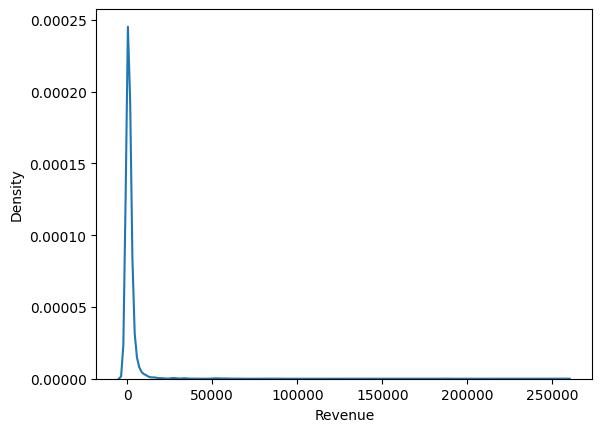

In [50]:
sns.kdeplot(df_clusters.Revenue)